In [5]:
import numpy as np
import _somkernels
import cupy as cp
import math
import som

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("batchsom").config("spark.executor.memory", "4gb").getOrCreate()
sc = spark.sparkContext

"""
Para el desarrollo del SOM se considera la versión batch del mismo, puesto que
escala en base al número de muestras utilizadas
"""

# Dataset de ejemplo para realizar clustering
N = 1000
d = 100

np.random.seed(30)
dataset = np.random.ranf((N, d))

# Dimensiones del mapa generado e inicialización
rows = 10
cols = 10

In [6]:
def gpu_work_iter(d, weights, sigma_squared, tpb=128):
    # Declarada función interna para devolverla y poder utilizar
    # múltiples parámetros al llamar a mapPartitions
    def _gpu_work(data):
        # 1. Procesamos el dataset
        inp = cp.asarray(list(data), dtype=cp.float32)
        # Utilizando cupy nos permitimos acceder a los datos en el kernel de forma bidimensional
        inp = cp.reshape(inp, (inp.size // d, d))
        
        # 2. Generamos un estructura en el dispositivo para almacenar las distancias
        my_distances = cp.empty((inp.shape[0], weights.shape[0] * weights.shape[1]))
        # 3. Pasamos los pesos de la iteración actual al dispositivo
        d_weights = cp.array(weights, dtype=cp.float32)
        # 3. Calculamos el número de bloques necesario para el kernel.
        blocks = inp.shape[0] * weights.shape[0] * weights.shape[1] // tpb + 1
        # 4. Lanzamos el kernel Numba para calcular las distancias euclídeas
        _somkernels.batch_euclidean_distance[blocks, tpb](inp, d_weights, my_distances)
        # 5. Lanzamos reducciones para encontrar la BMU de cada muestra
        bmu = cp.argmin(my_distances, axis=1)
        bmu_row = bmu // weights.shape[1]
        bmu_col = bmu % weights.shape[1] 
    
    
        # 6. Calculamos numeradores y denominadores asociados
        #    de la BMU de cada muestra y su vecindario
        blocks = inp.shape[0] // tpb + 1
        num = cp.zeros(weights.shape[0] * weights.shape[1] * weights.shape[2], cp.float32)
        den = cp.zeros(weights.shape[0] * weights.shape[1], cp.float32)
        _somkernels.prepare_update[blocks, tpb](bmu_row, bmu_col, inp, num, den, weights.shape[0], weights.shape[1], sigma_squared)
        
        return num.get(), den.get()
    return _gpu_work



In [7]:
def spark_based_batch_som(sc, dataset, max_iters, rows, cols, smooth_iters=None, sigma_0=10, 
                          sigma_f=0.1, tau=400, seed=None, tpb=128):
    # 1. Inicializamos semillas pseudoaleatorias
    np.random.seed(seed)
    cp.random.seed(seed)
    
    # 2. Inicializamos la matriz de pesos original (CPU maestro)
    d = dataset.shape[1]
    weights = np.random.ranf((rows, cols, d))
    
    # 3. Generamos un rdd con las muestras del dataset
    rdd_data = sc.parallelize(dataset)
    
    # 4. Bucle del algoritmo
    for t in range(max_iters):
        # 4.a Actualziamos los parámetros de control si procede (CPU maestro)
        if smooth_iters is None or t < max_iters:
            sigma = sigma_0 * math.exp((-t/tau))
        else:
            sigma = sigma_f
            
        sigma_squared = sigma * sigma
        
        # 4.b Cada nodo del clúster de spark trabajará con un subconjunto
        # de las muestras del RDD para encontrar la BMU y realizar la suma
        # parcial de su ecucación de actualización de pesos
        out = rdd_data.mapPartitions(gpu_work_iter(d, weights, sigma_squared))
        
        # 5 El nodo CPU maestro junta las cálculos parciales de los pesos
        out = out.collect()
        # 5.1 Juntar sumas parciales
        nums = np.zeros(weights.shape[0] * weights.shape[1] * weights.shape[2], dtype=np.float32)
        dens = np.zeros(weights.shape[0] * weights.shape[1], dtype=np.float32)
        for i in range(0, len(out), 2):
            nums = nums + out[i]
            dens = dens + out[i + 1]
            
        # 5.2 Actualizar pesos para siguiente iteración
        nums = nums.reshape(weights.shape)
        dens = dens.reshape((weights.shape[0], weights.shape[1]))
        for i in range(rows):
            for j in range(cols):
                if dens[i,j] != 0:
                    weights[i, j] = nums[i,j] / dens[i, j, np.newaxis]
      
    return weights

In [8]:
weights = spark_based_batch_som(sc, dataset, 50, rows, cols, seed=30)

In [9]:
mysom = som.SOM(rows, cols, d)
mysom.dataset = dataset
mysom.weights = weights
print(f'Error cuantificación {mysom.quantification_error()}')
print(f'Error topográfico {mysom.topography_error()}')

Error cuantificación 2.8423436679069956
Error topográfico 0.029


In [10]:
"""
Los resultados anteriores son coherentes con los otros experimentos que tengo desarrollados para ese tamaño sin usar Spark.
Para comprobar visualmente el correcto funcionamiento del mismo
aplicamos el ejemplo de las caras
"""
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
    
faces = fetch_olivetti_faces()['data']
rows = 20
cols = 20
d=faces.shape[1]
weights = spark_based_batch_som(sc, faces, 50, rows, cols, sigma_0=7, seed=30)


Error cuantificación 6.526832986443377
Error topográfico 0.11


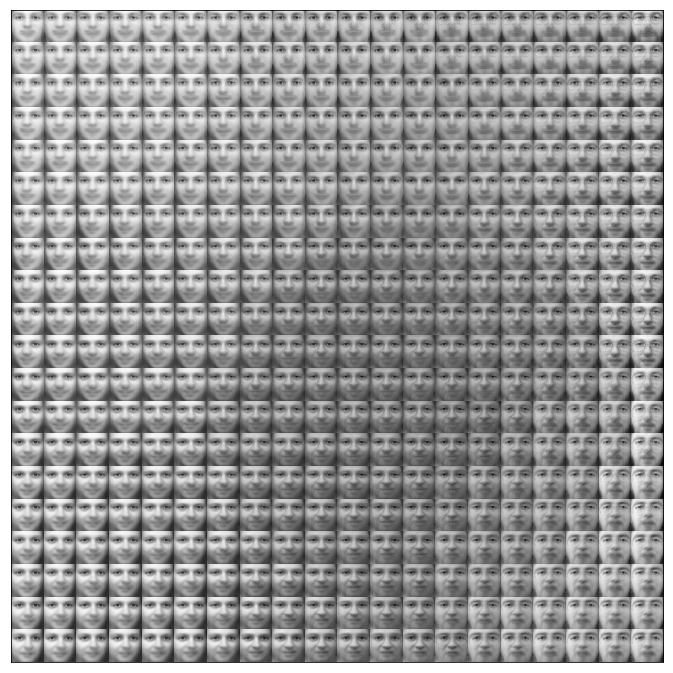

In [12]:
mysom = som.SOM(rows, cols, d)
mysom.dataset = faces
mysom.weights = weights
    
print(f'Error cuantificación {mysom.quantification_error()}')
print(f'Error topográfico {mysom.topography_error()}')

W = weights
pattern_length = faces.shape[1]
pattern_width = pattern_height = int(np.sqrt(pattern_length))
matrix_side = 20
matrix_w = np.empty((matrix_side * pattern_height, matrix_side * pattern_width))
matrix_w *= 255


for i in range(matrix_side):
    for j in range(matrix_side):
        matrix_w[i * pattern_height:i * pattern_height + pattern_height, 
j * pattern_height:j * pattern_height + pattern_width] = W[i, j].reshape((pattern_height, pattern_width)) * 255.0
fig, ax = plt.subplots(figsize=(12,12))

ax.matshow(matrix_w.tolist(), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

plt.show()
